In [1]:
# import required packages
import shutup
# shutup.please() # deprecation warnings are driving me mad
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI
from subgroup_detection import detect_subgroups, compute_rbo_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

In [54]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [2]:
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset('compas_two_year_clean', data_source='imodels')
X = pd.DataFrame(X, columns=feature_names)

In [3]:
# we add an id column to the dataset to track potential subgroups
X['id'] = np.arange(X.shape[0])

# the propublica study narrowed the dataset to only African-American and
# Caucasian defendants, and doing so keeps the vast majority of the data,
# so we will do the same.
y = y[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]
X = X[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]

# now that we have narrowed the dataset, we should remove the one-hot encodings
# of variables that are consistently zero, such as the other ethnicities.
# we also drop age because the binned 'age category' is preferred here.
X = X.drop(["race:Asian", "race:Hispanic", "race:Native_American",
            "race:Other", "age"], axis = 1)

In [4]:
# split data into training and testing sets
# we won't actually use the test set here though, since 'discovery' would be
# a post-hoc analysis in real life
# proportion of training data is small so rf+ can fit without taking hours
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [5]:
print("Total Proportion of Recidivism:", y.mean())
print("Proportion of Recidivism in Training Data:", y_train.mean())
print("Total Proportion of African-American Defendants:",
      X["race:African-American"].mean())
print("Proportion of African-American Defendants in Training Data:",
      X_train["race:African-American"].mean())
print("Total Proportion of Caucasian Defendants:",
      X["race:Caucasian"].mean())
print("Proportion of Caucasian Defendants in Training Data:",
      X_train["race:Caucasian"].mean())
print("Total Proportion of Male Defendants:",
      X["sex:Male"].mean())
print("Proportion of Male Defendants in Training Data:",
      X_train["sex:Male"].mean())
print("Total Proportion of Female Defendants:",
      X["sex:Female"].mean())
print("Proportion of Female Defendants in Training Data:",
      X_train["sex:Female"].mean())

Total Proportion of Recidivism: 0.5015157256536567
Proportion of Recidivism in Training Data: 0.5064970221981592
Total Proportion of African-American Defendants: 0.6015536
Proportion of African-American Defendants in Training Data: 0.5979968
Total Proportion of Caucasian Defendants: 0.39844638
Proportion of Caucasian Defendants in Training Data: 0.40200326
Total Proportion of Male Defendants: 0.80466086
Proportion of Male Defendants in Training Data: 0.80915
Total Proportion of Female Defendants: 0.19533914
Proportion of Female Defendants in Training Data: 0.19085003


In [6]:
# fit RF+ model
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_plus = RandomForestPlusClassifier(rf)
rf_plus.fit(X_train, y_train)
y_pred = rf_plus.predict(X_test)

# compute accuracy on the test set
accuracy = np.mean(y_pred == y_test)
print(f'RF+ Test Set Accuracy: {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.1min finished


RF+ Test Set Accuracy: 0.6199494949494949


In [7]:
# get Local MDI+ feature importances
mdi_explainer = AloRFPlusMDI(rf_plus,evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(np.asarray(X_train), y_train)
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [8]:
# detect subgroups by calculating pairwise rbo matrix
# and feeding it to hierarchical clustering
rbo_matrix = compute_rbo_matrix(mdi_rankings, p = 0.9)


/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


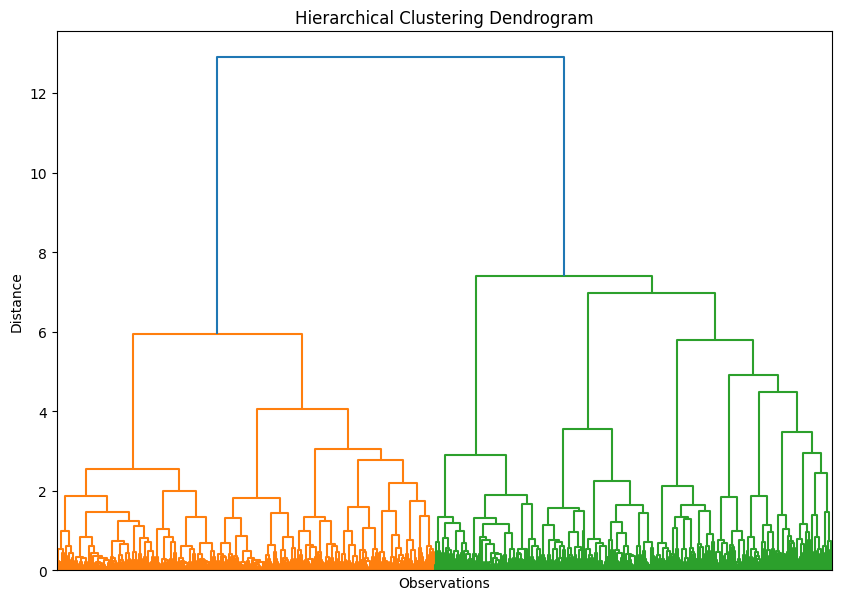

In [9]:
clusters = detect_subgroups(rbo_matrix, linkage_method = 'ward')

In [10]:
# add clusters as column to X_train
X_train['cluster'] = clusters

# proportion of observations in each cluster
cluster_proportions = X_train['cluster'].value_counts(normalize=True)
# remove name from cluster_proportions
cluster_proportions.index.name = None
print(cluster_proportions)

2    0.51164
1    0.48836
Name: proportion, dtype: float64


In [11]:
# calculate proportions of each cluster by gender
prop_women = X_train[X_train['sex:Female'] == 1]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for Women:")
prop_women.index.name = None
print(prop_women)

prop_men = X_train[X_train['sex:Male'] == 1]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for Men:")
prop_men.index.name = None
print(prop_men)

Cluster Proportions for Women:
1    0.52766
2    0.47234
Name: proportion, dtype: float64
Cluster Proportions for Men:
2    0.52091
1    0.47909
Name: proportion, dtype: float64


In [12]:
# calculate proportions of each cluster by race/ethnicity
prop_aa = X_train[X_train['race:African-American'] == 1]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for African-Americans:")
prop_aa.index.name = None
print(prop_aa)

prop_cau = X_train[X_train['race:Caucasian'] == 1]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for Caucasians:")
prop_cau.index.name = None
print(prop_cau)

Cluster Proportions for African-Americans:
2    0.507922
1    0.492078
Name: proportion, dtype: float64
Cluster Proportions for Caucasians:
2    0.517172
1    0.482828
Name: proportion, dtype: float64


In [13]:
# calculate proportions of each cluster by actual recidivism
prop_recid = X_train[y_train == 1]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for Recidivists")
prop_recid.index.name = None
print(prop_recid)

prop_no_recid = X_train[y_train == 0]['cluster'].value_counts(normalize=True)
print("Cluster Proportions for Non-Recidivists")
prop_no_recid.index.name = None
print(prop_no_recid)

Cluster Proportions for Recidivists
2    0.587921
1    0.412079
Name: proportion, dtype: float64
Cluster Proportions for Non-Recidivists
1    0.566648
2    0.433352
Name: proportion, dtype: float64


In [14]:
import numpy as np
import pandas as pd

def permutation_test(df, variable, num_permutations=5000):
    # calculate the observed difference in means
    df = df.copy()
    var_true= df[df[variable] == 1]
    prop_cluster1 = var_true[var_true["cluster"]==1].shape[0]/var_true.shape[0]
    prop_cluster2 = var_true[var_true["cluster"]==2].shape[0]/var_true.shape[0]
    observed_diff = prop_cluster1 - prop_cluster2
    
    # get number of observations in cluster1
    cluster1 = df[df["cluster"]==1].shape[0]
    
    # perform permutations
    perm_diffs = []
    for _ in range(num_permutations):
        dfarr = np.asarray(df)
        np.random.shuffle(np.asarray(dfarr))
        dfarr[:cluster1,-1] = 1
        dfarr[cluster1:,-1] = 2
        dfarr = pd.DataFrame(dfarr, columns=df.columns)
        var_true= dfarr[dfarr[variable] == 1]
        prop_cluster1 = var_true[var_true["cluster"]==1].shape[0]/var_true.shape[0]
        prop_cluster2 = var_true[var_true["cluster"]==2].shape[0]/var_true.shape[0]
        perm_diff = prop_cluster1 - prop_cluster2
        perm_diffs.append(perm_diff)
    
    # calculate the p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value


In [15]:
observed_diff, p_value = permutation_test(X_train, "race:African-American")
print("Permutation Results for race:African-American")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for race:African-American
Observed Difference in Clusters: -0.015844273426889988
Permutation-Test p-Value: 0.7282


In [16]:
observed_diff, p_value = permutation_test(X_train, "race:Caucasian")
print("Permutation Results for race:Caucasian")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for race:Caucasian
Observed Difference in Clusters: -0.03434343434343434
Permutation-Test p-Value: 0.2958


In [17]:
observed_diff, p_value = permutation_test(X_train, "sex:Female")
print("Permutation Results for sex:Female")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for sex:Female
Observed Difference in Clusters: 0.05531914893617018
Permutation-Test p-Value: 0.1894


In [18]:
observed_diff, p_value = permutation_test(X_train, "sex:Male")
print("Permutation Results for sex:Male")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for sex:Male
Observed Difference in Clusters: -0.04182000669120112
Permutation-Test p-Value: 0.012


In [19]:
observed_diff, p_value = permutation_test(X_train, "c_charge_degree:F")
print("Permutation Results for Felony Charge")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for Felony Charge
Observed Difference in Clusters: -0.03700657894736842
Permutation-Test p-Value: 0.1398


In [20]:
observed_diff, p_value = permutation_test(X_train, "c_charge_degree:M")
print("Permutation Results for Misdemeanor Charge")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for Misdemeanor Charge
Observed Difference in Clusters: 0.003169572107765417
Permutation-Test p-Value: 0.9496


In [21]:
# get average jail time in each cluster
avg_jail_time = X_train.groupby('cluster')['c_jail_time'].mean()
avg_jail_time

cluster
1    14.08592
2    15.72963
Name: c_jail_time, dtype: float32

In [22]:
X_train_with_y = X_train.copy()
X_train_with_y["y"] = y_train
observed_diff, p_value = permutation_test(X_train_with_y, "y")
print("Permutation Results for Recidivism Outcome")
print("Observed Difference in Clusters:", observed_diff)
print("Permutation-Test p-Value:", p_value)

Permutation Results for Recidivism Outcome
Observed Difference in Clusters: -0.17584179583110632
Permutation-Test p-Value: 0.0


In [48]:
# Sort the DataFrame based on cluster membership
kept_features = list(range(1,11)) + [11] + list(range(15, len(feature_names)))
kept_features = np.asarray(feature_names)[kept_features]
mdi_copy = pd.DataFrame(mdi, columns=kept_features).copy()
mdi
mdi_copy['cluster'] = clusters
df_sorted = mdi_copy.sort_values('cluster').reset_index(drop=True)

# Drop the cluster column for the heatmap
data_sorted = df_sorted.drop('cluster', axis=1)


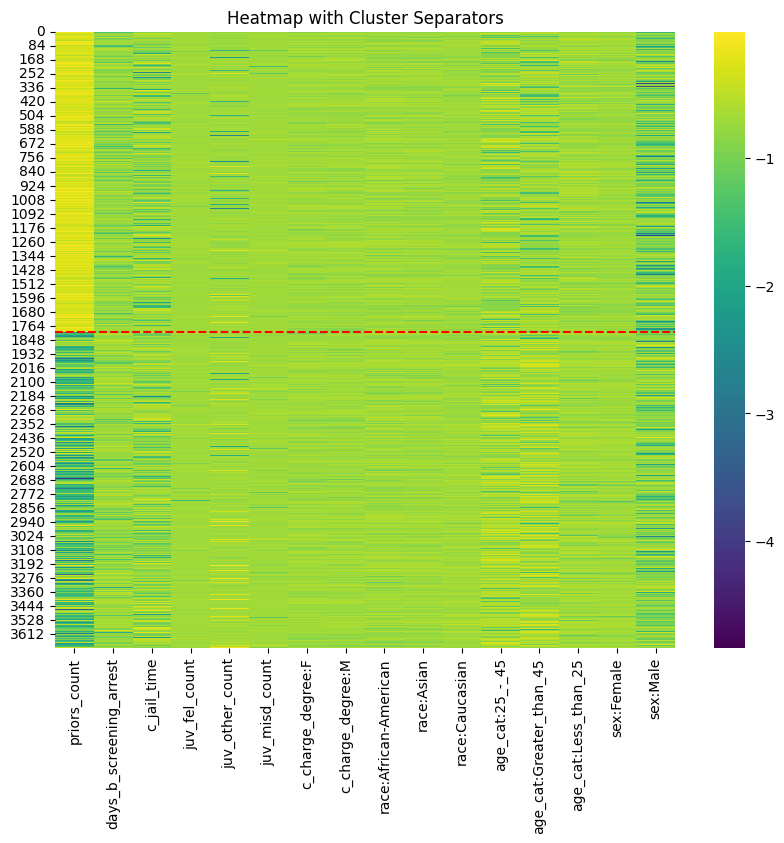

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_sorted, cmap='viridis', cbar=True)

# Add dotted horizontal lines to separate clusters
current_cluster = df_sorted['cluster'].iloc[0]
for idx in range(1, len(df_sorted)):
    if df_sorted['cluster'].iloc[idx] != current_cluster:
        plt.axhline(idx, color='red', linestyle='--')
        current_cluster = df_sorted['cluster'].iloc[idx]

plt.title('Heatmap with Cluster Separators')
plt.show()

In [50]:
# get average number of priors (priors_count) in cluster 1 and cluster 2
avg_priors_cluster1 = X_train[X_train['cluster'] == 1]['priors_count'].mean()
avg_priors_cluster2 = X_train[X_train['cluster'] == 2]['priors_count'].mean()
print("Average Number of Priors in Cluster 1:", avg_priors_cluster1)
print("Average Number of Priors in Cluster 2:", avg_priors_cluster2)

Average Number of Priors in Cluster 1: 4.2267184
Average Number of Priors in Cluster 2: 2.7962964


In [52]:
# get average number of priors for those who recidivated and those who did not
avg_priors_recid = X_train[y_train == 1]['priors_count'].mean()
avg_priors_no_recid = X_train[y_train == 0]['priors_count'].mean()
print("Average Number of Priors for Recidivists:", avg_priors_recid)
print("Average Number of Priors for Non-Recidivists:", avg_priors_no_recid)

Average Number of Priors for Recidivists: 4.91876
Average Number of Priors for Non-Recidivists: 2.0334613


In [53]:
# get proportion of cluster 1 that recidivated and cluster 2 that recidivated
prop_recid_cluster1 = X_train[(X_train['cluster'] == 1) & (y_train == 1)].shape[0] / X_train[X_train['cluster'] == 1].shape[0]
prop_recid_cluster2 = X_train[(X_train['cluster'] == 2) & (y_train == 1)].shape[0] / X_train[X_train['cluster'] == 2].shape[0]
print("Proportion of Cluster 1 that Recidivated:", prop_recid_cluster1)
print("Proportion of Cluster 2 that Recidivated:", prop_recid_cluster2)

Proportion of Cluster 1 that Recidivated: 0.42738359201773835
Proportion of Cluster 2 that Recidivated: 0.582010582010582
